In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
from datetime import timedelta
import tensorflow as tf

import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 
import matplotlib.pyplot as plt
!pip install eli5
from eli5 import show_weights
from eli5 import explain_prediction
from IPython.display import display
import eli5
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error,mean_absolute_error

import seaborn as sns
from sklearn.metrics import r2_score
import scipy.stats as stats
  

     |████████████████████████████████| 106 kB 5.2 MB/s 


# SST 

URL GET DOWNLOAD

In [2]:
file_url = "https://downloads.psl.noaa.gov/Datasets/COBE/sst.mon.mean.nc"
	
r = requests.get(file_url, stream = True) 

with open("./SST.nc", "wb") as file: 
	for block in r.iter_content(chunk_size = 1024): 
		if block: 
			file.write(block) 
   
size = os.path.getsize('./SST.nc') 
print('Size of file is', size, 'bytes')

Size of file is 163024403 bytes


## NetCDF Manipulation

Opening NetCDF File

In [3]:
ds_SST = xr.open_dataset("./SST.nc" , decode_times=True)
ds_SST

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1575)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2022-03-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

Limiting Data to Tropical Storm Main Formation Zone

In [4]:
ds_SST_sub = ds_SST.where(((ds_SST.lon>40 )&(ds_SST.lon<80) & (ds_SST.lat>10 )&(ds_SST.lat<20)  ), drop=True)

Putting Data into a Pandas DataFrame

In [5]:
ds_SST_sub['time'][0]

<xarray.DataArray 'time' ()>
array('1891-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1891-01-01
Attributes:
    long_name:           Time
    delta_t:             0000-01-00 00:00:00
    avg_period:          0000-01-00 00:00:00
    prev_avg_period:     0000-00-01 00:00:00
    axis:                T
    standard_name:       time
    coordinate_defines:  start
    actual_range:        [    0. 47906.]

In [6]:
df_sst = pd.DataFrame()
df_sst['time'] = np.array((ds_SST_sub['time']))
df_sst['sst'] = ''
for i in range(len(df_sst)):
  #df_sst['time'][i] = pd.Timestamp(1891, 1, 1) + timedelta(days= df_sst['time'][i])
  df_sst['sst'][i] = np.array((ds_SST_sub['sst'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df_sst

,time,sst
0,1891-01-01,"[[27.16, nan, nan, nan, nan, nan, nan, nan, na..."
1,1891-02-01,"[[26.29, nan, nan, nan, nan, nan, nan, nan, na..."
2,1891-03-01,"[[26.1775, nan, nan, nan, nan, nan, nan, nan, ..."
3,1891-04-01,"[[28.0025, nan, nan, nan, nan, nan, nan, nan, ..."
4,1891-05-01,"[[29.7825, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...
1570,2021-11-01,"[[30.6625, nan, nan, nan, nan, nan, nan, nan, ..."
1571,2021-12-01,"[[29.29, nan, nan, nan, nan, nan, nan, nan, na..."
1572,2022-01-01,"[[27.605, nan, nan, nan, nan, nan, nan, nan, n..."
1573,2022-02-01,"[[26.2025, nan, nan, nan, nan, nan, nan, nan, ..."


Fill Nan data with 0

In [8]:
#for i in range(len(df_sst)):
  #df_sst["sst"][i][np.isnan(df_sst["sst"][i])] = 0

Filling nan data with near by neighbours

In [9]:
df_sst['sst'][0][0]

array([27.16  ,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan, 24.59  , 24.6275, 24.71  ,
       24.77  , 24.79  , 24.8275, 24.85  , 24.955 , 25.0175, 25.18  ,
       25.3225, 25.39  , 25.5425, 25.595 , 25.6825,     nan,     nan,
           nan,     nan,     nan,     nan,     nan], dtype=float32)

In [10]:
from scipy.interpolate import NearestNDInterpolator
for i in range(len(df_sst)):
  data = df_sst['sst'][i] 
  mask = np.where(~np.isnan(data))
  interp = NearestNDInterpolator(np.transpose(mask), data[mask])
  filled_data = interp(*np.indices(data.shape))
  df_sst['sst'][i] = filled_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [11]:
df_sst['sst'][0][0]

array([27.16  , 27.16  , 26.785 , 26.785 , 26.785 , 26.785 , 25.6525,
       24.755 , 24.825 , 24.8825, 24.8825, 24.8825, 24.8825, 24.6975,
       24.6975, 24.6975, 24.65  , 24.65  , 24.59  , 24.6275, 24.71  ,
       24.77  , 24.79  , 24.8275, 24.85  , 24.955 , 25.0175, 25.18  ,
       25.3225, 25.39  , 25.5425, 25.595 , 25.6825, 25.6825, 25.6825,
       25.6825, 25.6825, 25.6825, 26.88  , 26.88  ], dtype=float32)

Looking at April Data

In [12]:
df_sst['Month'] = 0
for i in range(len(df_sst)):
  df_sst['Month'][i] =df_sst['time'][i].month

df_sst['Year'] = 0
for i in range(len(df_sst)):
  df_sst['Year'][i] =df_sst['time'][i].year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [13]:
df_sst_april = df_sst.loc[df_sst['Month'] == 3]

In [14]:
df_VK08_TCCount = pd.read_table('./Data/VK08_TCCounts_1878-2020.dat', sep="\s+", header=None)
df_VK08_TCCount = df_VK08_TCCount.rename(columns={0: "Year", 1:"VK08_TCCount"}).copy()
df_VK08_TCCount

,Year,VK08_TCCount
0,1878,15.370
1,1879,11.308
2,1880,14.084
3,1881,10.234
4,1882,9.183
...,...,...
138,2016,15.000
139,2017,17.000
140,2018,15.000
141,2019,18.000


In [15]:
df_sst_final = pd.merge(df_sst_april, df_VK08_TCCount, on="Year", how="left")

In [16]:
df_sst_final['VK08_TCCount']

0      12.202
1      11.101
2      14.041
3       9.309
4       8.074
        ...  
127    15.000
128    18.000
129    30.000
130       NaN
131       NaN
Name: VK08_TCCount, Length: 132, dtype: float64

In [17]:
df_sst_final.tail(30)

,time,sst,Month,Year,VK08_TCCount
102,1993-03-01,"[[26.1825, 26.1825, 26.4675, 26.4675, 26.4675,...",3,1993,8.0
103,1994-03-01,"[[26.39, 26.39, 26.6075, 26.6075, 26.6075, 26....",3,1994,7.0
104,1995-03-01,"[[26.515, 26.515, 26.785, 26.785, 26.785, 26.7...",3,1995,19.0
105,1996-03-01,"[[26.5525, 26.5525, 26.905, 26.905, 26.905, 26...",3,1996,13.0
106,1997-03-01,"[[25.67, 25.67, 26.035, 26.035, 26.035, 26.035...",3,1997,8.0
107,1998-03-01,"[[26.0875, 26.0875, 26.6125, 26.6125, 26.6125,...",3,1998,14.0
108,1999-03-01,"[[27.3375, 27.3375, 27.315, 27.315, 27.315, 27...",3,1999,12.0
109,2000-03-01,"[[26.93, 26.93, 27.275, 27.275, 27.275, 27.275...",3,2000,15.0
110,2001-03-01,"[[27.235, 27.235, 27.2, 27.2, 27.2, 27.2, 26.9...",3,2001,15.0
111,2002-03-01,"[[27.1, 27.1, 27.225, 27.225, 27.225, 27.225, ...",3,2002,12.0


In [18]:
df_sst_final['Outlier'] = (df_sst_final['VK08_TCCount'] > 18)

In [19]:
df_sst_final['Outlier'].value_counts()

False    125
True       7
Name: Outlier, dtype: int64

In [20]:
df_sst_final['Outlier'] = df_sst_final['Outlier'].map({True:1, False:0})

In [21]:
#df_sst_final = df_sst_final.loc[df_sst_final['Year'] > 1950]
#df_sst_final.reset_index(inplace=True, drop=True)

In [22]:
df_sst_final['sst'][0].shape

(10, 40)

# SSH

URL GET DOWNLOAD

In [23]:
file_url = "https://iridl.ldeo.columbia.edu/SOURCES/.CARTON-GIESE/.SODA/.v2p2p4/ssh/data.nc"
	
r = requests.get(file_url, stream = True) 

with open("./data.nc", "wb") as file: 
	for block in r.iter_content(chunk_size = 1024): 
		if block: 
			file.write(block) 

size = os.path.getsize('./data.nc') 
print('Size of file is', size, 'bytes')

Size of file is 1573874020 bytes


## NetCDF Manipulation

In [24]:
ds_ssh = xr.open_dataset("./data.nc" , decode_times=False)
def fix_calendar(ds, timevar='time'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

ds_ssh = fix_calendar(ds_ssh)
ds_ssh = xr.decode_cf(ds_ssh)
ds_ssh

<xarray.Dataset>
Dimensions:  (lat: 330, lon: 720, time: 1656)
Coordinates:
  * lat      (lat) float32 -75.25 -74.75 -74.25 -73.75 ... 88.25 88.75 89.25
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) object 1871-01-16 00:00:00 ... 2008-12-16 00:00:00
Data variables:
    ssh      (time, lat, lon) float32 ...

In [25]:
ds_ssh = ds_ssh.where(((ds_ssh.lon > 40 ) & (ds_ssh.lon < 80 ) & (ds_ssh.lat > 10) & (ds_ssh.lat <20)), drop=True)

In [26]:
ds_ssh['ssh']

<xarray.DataArray 'ssh' (time: 1656, lat: 20, lon: 80)>
array([[[       nan,        nan,        nan, ...,        nan,
         0.47368455, 0.4705949 ],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.47322145],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.45891967],
        ...,
        [0.12844115, 0.12032223, 0.14449105, ...,        nan,
                nan,        nan],
        [0.11885963, 0.10722669, 0.04978143, ...,        nan,
                nan,        nan],
        [0.09120873, 0.04488847,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
         0.49529132, 0.49132225],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.4916404 ],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.47177067],
...
        [0.09632535, 0.09185884, 0.1074802 , ...,        nan,
                nan,        nan],
        [0.08791679, 0.09135956, 0.06385598, ...,        nan,
                nan,        nan],
        [0.08047532, 0.06369876,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
         0.552477  , 0.5522664 ],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.5573779 ],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.54433674],
        ...,
        [0.11998665, 0.11525779, 0.13860157, ...,        nan,
                nan,        nan],
        [0.11312491, 0.11219507, 0.07148191, ...,        nan,
                nan,        nan],
        [0.09691926, 0.06839473,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 10.25 10.75 11.25 11.75 ... 18.25 18.75 19.25 19.75
  * lon      (lon) float32 40.25 40.75 41.25 41.75 ... 78.25 78.75 79.25 79.75
  * time     (time) object 1871-01-16 00:00:00 ... 2008-12-16 00:00:00
Attributes:
    pointwidth:     1.0
    standard_name:  sea_surface_height
    units:          meters
    long_name:      SEA SURFACE HEIGHT

In [27]:
np.array(ds_ssh['ssh']).shape

(1656, 20, 80)

In [28]:

df_ssh= pd.DataFrame()
np.array((ds_ssh['time'][0]))
df_ssh['time'] = np.array((ds_ssh['time']))
df_ssh['ssh'] = ''
for i in range(1656):
  df_ssh['ssh'][i] = np.array((ds_ssh['ssh'][i]))


In [29]:
df_ssh['Month'] = 0
for i in range(len(df_ssh)):
  df_ssh['Month'][i] =df_ssh['time'][i].month

df_ssh['Year'] = 0
for i in range(len(df_ssh)):
  df_ssh['Year'][i] =df_ssh['time'][i].year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [30]:
df_ssh_april = df_ssh.loc[df_ssh['Month'] == 4]

In [31]:
type(df_ssh_april['ssh'][3])

numpy.ndarray

In [33]:
df_VK08_TCCount = pd.read_table('./Data/VK08_TCCounts_1878-2020.dat', sep="\s+", header=None)
df_VK08_TCCount = df_VK08_TCCount.rename(columns={0: "Year", 1:"VK08_TCCount"}).copy()
df_VK08_TCCount

,Year,VK08_TCCount
0,1878,15.370
1,1879,11.308
2,1880,14.084
3,1881,10.234
4,1882,9.183
...,...,...
138,2016,15.000
139,2017,17.000
140,2018,15.000
141,2019,18.000


In [34]:
df_ssh_final = pd.merge(df_ssh_april, df_VK08_TCCount, on="Year")

In [35]:
df_ssh_final['Outlier'] = (df_ssh_final['VK08_TCCount'] > 9)

In [36]:
df_ssh_final['Outlier'].value_counts()

True     75
False    56
Name: Outlier, dtype: int64

In [37]:
df_ssh_final['Outlier'] = df_ssh_final['Outlier'].map({True:1, False:0})

In [38]:
df_ssh_final['ssh'][0].shape

(20, 80)

In [39]:
len(df_ssh_final["ssh"][0])

20

In [40]:
df_ssh_final

,time,ssh,Month,Year,VK08_TCCount,Outlier
0,1878-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.24...",4,1878,15.370,1
1,1879-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.22...",4,1879,11.308,1
2,1880-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.19...",4,1880,14.084,1
3,1881-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.19...",4,1881,10.234,1
4,1882-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.21...",4,1882,9.183,1
...,...,...,...,...,...,...
126,2004-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.18...",4,2004,15.000,1
127,2005-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.26...",4,2005,28.000,1
128,2006-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.30...",4,2006,10.000,1
129,2007-04-16 00:00:00,"[[nan, nan, nan, nan, nan, nan, nan, nan, 0.28...",4,2007,15.000,1


In [41]:
from scipy.interpolate import NearestNDInterpolator
for i in range(len(df_ssh_final)):
  data = df_ssh_final['ssh'][i] 
  mask = np.where(~np.isnan(data))
  interp = NearestNDInterpolator(np.transpose(mask), data[mask])
  filled_data = interp(*np.indices(data.shape))
  df_ssh_final['ssh'][i] = filled_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [42]:
df_ssh_final['ssh'][0].shape
for i in range(len(df_ssh_final['ssh'])):
  masterarray = []
  for x in range(len(df_ssh_final['ssh'][i])):
    subarray = []
    for y in range(len(df_ssh_final['ssh'][i][x])):
      if y%2 == 0:
        subarray.append(float(df_ssh_final['ssh'][i][x][y]))
    if x%2 == 0:
      masterarray.append(subarray)
  df_ssh_final['ssh'][i] = np.array(masterarray)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [43]:
df_ssh_final['ssh'][0].shape

(10, 40)

# Combine DataFrames


In [44]:
df_final = pd.merge(df_ssh_final[['Year', "ssh"]],df_sst_final, on="Year")

In [45]:
df_final['ssh'][9].shape

(10, 40)

In [46]:
df_final['sst'][0].shape

(10, 40)

In [47]:
df_final['SuperFeature'] = ''
for i in range(len(df_final['SuperFeature'])):
  array = []
  array.append(df_final['ssh'][i])
  array.append(df_final['sst'][i])
  df_final['SuperFeature'][i] = array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
df_final["SuperFeature"] = np.asarray(df_final["SuperFeature"])
for i in range(len(df_final["SuperFeature"])):
  df_final["SuperFeature"][i] = np.asarray(df_final["SuperFeature"][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
df_final

,Year,ssh,time,sst,Month,VK08_TCCount,Outlier,SuperFeature
0,1891,"[[0.23127134144306183, 0.23127134144306183, 0....",1891-03-01,"[[26.1775, 26.1775, 26.3875, 26.3875, 26.3875,...",3,12.202,0,"[[[0.23127134144306183, 0.23127134144306183, 0..."
1,1892,"[[0.23641836643218994, 0.23641836643218994, 0....",1892-03-01,"[[26.0775, 26.0775, 26.245, 26.245, 26.245, 26...",3,11.101,0,"[[[0.23641836643218994, 0.23641836643218994, 0..."
2,1893,"[[0.18914537131786346, 0.18914537131786346, 0....",1893-03-01,"[[25.5675, 25.5675, 25.7625, 25.7625, 25.7625,...",3,14.041,0,"[[[0.18914537131786346, 0.18914537131786346, 0..."
3,1894,"[[0.21780052781105042, 0.21780052781105042, 0....",1894-03-01,"[[26.1975, 26.1975, 26.3975, 26.3975, 26.3975,...",3,9.309,0,"[[[0.21780052781105042, 0.21780052781105042, 0..."
4,1895,"[[0.19949311017990112, 0.19949311017990112, 0....",1895-03-01,"[[26.72, 26.72, 26.7075, 26.7075, 26.7075, 26....",3,8.074,0,"[[[0.19949311017990112, 0.19949311017990112, 0..."
...,...,...,...,...,...,...,...,...
113,2004,"[[0.19565095007419586, 0.19565095007419586, 0....",2004-03-01,"[[26.8375, 26.8375, 27.1525, 27.1525, 27.1525,...",3,15.000,0,"[[[0.19565095007419586, 0.19565095007419586, 0..."
114,2005,"[[0.280181348323822, 0.280181348323822, 0.2801...",2005-03-01,"[[26.805, 26.805, 27.17, 27.17, 27.17, 27.17, ...",3,28.000,1,"[[[0.280181348323822, 0.280181348323822, 0.280..."
115,2006,"[[0.30151817202568054, 0.30151817202568054, 0....",2006-03-01,"[[27.3375, 27.3375, 27.4175, 27.4175, 27.4175,...",3,10.000,0,"[[[0.30151817202568054, 0.30151817202568054, 0..."
116,2007,"[[0.29450929164886475, 0.29450929164886475, 0....",2007-03-01,"[[26.905, 26.905, 27.3125, 27.3125, 27.3125, 2...",3,15.000,0,"[[[0.29450929164886475, 0.29450929164886475, 0..."


#SST CNN (Up to 2022 Use For Current Classification)

In [50]:
df_sst_final['sst'][0].shape

(10, 40)

In [51]:
for i in  range(len(df_sst_final['sst'])):
   array = []
   df_sst_final['sst'][i] = np.asarray(df_sst_final['sst'][i].reshape(10,40,1))
   for x in range(len(df_sst_final['sst'][i])):
     df_sst_final['sst'][i][x] = np.asarray(df_sst_final['sst'][i][x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
df_2008 = df_sst_final.loc[df_sst_final['Year'] == 2008]
df_2020 = df_sst_final.loc[df_sst_final['Year'] == 2020]
df_2005 = df_sst_final.loc[df_sst_final['Year'] == 2005]
df_2021 = df_sst_final.loc[df_sst_final['Year'] == 2021]
df_2022 = df_sst_final.loc[df_sst_final['Year'] == 2022]

X_2008 =   np.asarray(df_2008['sst'].to_list())
X_2020 =   np.asarray(df_2020['sst'].to_list())
X_2005 =   np.asarray(df_2005['sst'].to_list())
X_2021 =   np.asarray(df_2021['sst'].to_list())
X_2022 =   np.asarray(df_2022['sst'].to_list())


In [53]:
X_2021.shape

(1, 10, 40, 1)

In [54]:
df_sst_final.dropna(inplace=True)

In [55]:
X =  df_sst_final['sst'].to_list()
y =  df_sst_final['Outlier']

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=48)


X_train =  np.asarray(X_train)
X_test =  np.asarray(X_test)
y_train =  np.asarray(y_train)
y_test =  np.asarray(y_test)

In [57]:
X_predict =  np.asarray(X)
y_predict =  np.asarray(y)

In [58]:
tf.random.set_seed(48)

In [59]:
from tensorflow.keras import layers, Model, Sequential

model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(10,40,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 38, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 36, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 18, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 128)               442496    
                                                        

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False, gamma=1),
              metrics=['accuracy'])

In [62]:
history = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_test, y_test))

Epoch 1/25
3/3 [==============================] - 3s 312ms/step - loss: 1.1057 - accuracy: 0.7253 - val_loss: 0.6479 - val_accuracy: 0.9744
Epoch 2/25
3/3 [==============================] - 0s 92ms/step - loss: 1.7627 - accuracy: 0.9341 - val_loss: 0.4640 - val_accuracy: 0.9744
Epoch 3/25
3/3 [==============================] - 0s 125ms/step - loss: 0.8459 - accuracy: 0.9341 - val_loss: 0.1578 - val_accuracy: 0.9744
Epoch 4/25
3/3 [==============================] - 0s 139ms/step - loss: 0.2305 - accuracy: 0.9341 - val_loss: 0.1642 - val_accuracy: 0.9744
Epoch 5/25
3/3 [==============================] - 0s 85ms/step - loss: 0.2240 - accuracy: 0.7582 - val_loss: 0.1390 - val_accuracy: 0.9744
Epoch 6/25
3/3 [==============================] - 0s 99ms/step - loss: 0.1632 - accuracy: 0.9121 - val_loss: 0.0683 - val_accuracy: 0.9744
Epoch 7/25
3/3 [==============================] - 0s 84ms/step - loss: 0.2070 - accuracy: 0.9341 - val_loss: 0.0644 - val_accuracy: 0.9744
Epoch 8/25
3/3 [========

STATS


In [63]:
result_df = model.predict(X_predict)

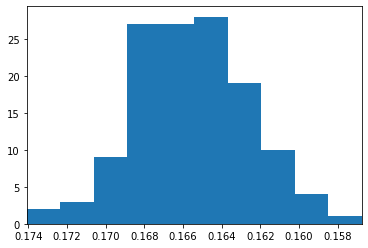

In [64]:
plt.hist(result_df)
plt.xlim(max(result_df),min(result_df))
plt.show()

In [65]:
model.predict(X_2020)

array([[0.16172117]], dtype=float32)

In [66]:
Score2021 = model.predict(X_2021)[0]
Score2021

array([0.15934801], dtype=float32)

In [67]:
Score2022  = model.predict(X_2022)[0]
Score2022

array([0.16119182], dtype=float32)

(array([ 7., 30., 31., 34., 17.,  4.,  5.,  0.,  0.,  2.]),
 array([ 2.181 ,  4.9629,  7.7448, 10.5267, 13.3086, 16.0905, 18.8724,
        21.6543, 24.4362, 27.2181, 30.    ]),
 <a list of 10 Patch objects>)

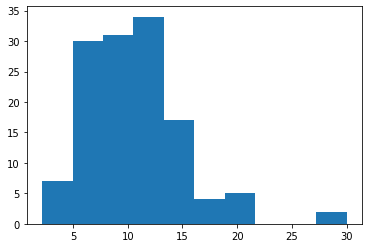

In [68]:
plt.hist(df_sst_final['VK08_TCCount'])

In [69]:
from scipy.stats import chisquare
result_list = []
count_list = []

In [70]:
for i in range(len(result_df)):
  result_list.append(float(result_df[i]))

for i in range(len(df_sst_final['VK08_TCCount'])):
  count_list.append(df_sst_final['VK08_TCCount'][i])

In [71]:
chisquare(result_list,f_exp=count_list)

Power_divergenceResult(statistic=1330.434122573912, pvalue=1.5925463692001962e-198)

In [72]:
df_regressionAnlysis = pd.DataFrame()
df_regressionAnlysis['StormCount'] = df_sst_final['VK08_TCCount']
df_regressionAnlysis['Year'] = df_sst_final['Year']
df_regressionAnlysis['result']= result_df

In [73]:
MeanScore = df_regressionAnlysis['result'].mean()

OutlierYearList = []
for i in range(len(df_regressionAnlysis)):
  if df_regressionAnlysis['result'][i] < MeanScore:
    OutlierYearList.append(df_regressionAnlysis['Year'][i])

In [74]:
MeanScore

0.16552495956420898

In [75]:
df_regressionAnlysis

,StormCount,Year,result
0,12.202,1891,0.164104
1,11.101,1892,0.166680
2,14.041,1893,0.169944
3,9.309,1894,0.167185
4,8.074,1895,0.168136
...,...,...,...
125,15.000,2016,0.156758
126,17.000,2017,0.161899
127,15.000,2018,0.162083
128,18.000,2019,0.165381


In [76]:
Y_data = df_regressionAnlysis['StormCount']
X_data = df_regressionAnlysis['result']

In [77]:
m, b = np.polyfit(X_data, Y_data, 1)

In [78]:
df_regressionAnlysis

,StormCount,Year,result
0,12.202,1891,0.164104
1,11.101,1892,0.166680
2,14.041,1893,0.169944
3,9.309,1894,0.167185
4,8.074,1895,0.168136
...,...,...,...
125,15.000,2016,0.156758
126,17.000,2017,0.161899
127,15.000,2018,0.162083
128,18.000,2019,0.165381


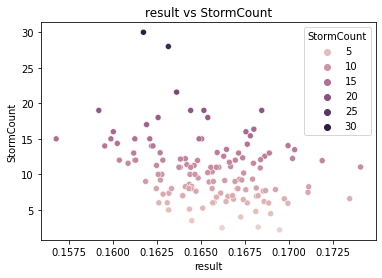

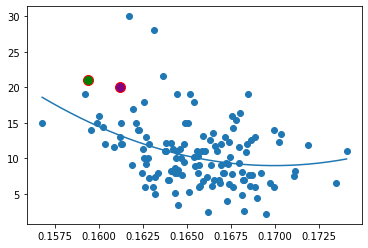

           2
5.522e+04 x - 1.877e+04 x + 1604
0.13329959672716074


In [79]:
dataset = df_regressionAnlysis
sns.scatterplot(data=dataset, x='result', 
                y='StormCount', hue='StormCount')
  
plt.title('result vs StormCount')
plt.xlabel('result')
plt.ylabel('StormCount')
plt.show()
  
# degree 2 polynomial fit or quadratic fit
model2 = np.poly1d(np.polyfit(dataset['result'],
                             dataset['StormCount'], 2))
  
# polynomial line visualization
polyline = np.linspace(max(dataset['result']), min(dataset['result']), 1000)
plt.scatter(dataset['result'], dataset['StormCount'])
plt.plot(polyline, model2(polyline))
plt.plot(Score2021, 21, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.plot(Score2022, 20, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="purple")
plt.show()
  
print(model2)
  
# r square metric
print(r2_score(dataset['StormCount'], 
               model2(dataset['result'])))

#3D Vertically Stacked Multi-Feature CNN (Only up to 2008)

In [80]:
for i in  range(len(df_final)):
   array = []
   df_final['SuperFeature'][i] = np.asarray(df_final['SuperFeature'][i].reshape(2,10,40,1))
   for x in range(len(df_final['SuperFeature'][i])):
     df_final['SuperFeature'][i][x] = np.asarray(df_final['SuperFeature'][i][x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
#df_2008 = df_sst_final.loc[df_sst_final['Year'] == 2008]
#df_2020 = df_sst_final.loc[df_sst_final['Year'] == 2020]
df_2005 = df_final.loc[df_final['Year'] == 2005]
#df_2021 = df_sst_final.loc[df_sst_final['Year'] == 2021]
#df_2022 = df_sst_final.loc[df_sst_final['Year'] == 2022]

#X_2008 =   np.asarray(df_2008['sst'].to_list())
#X_2020 =   np.asarray(df_2020['sst'].to_list())
X_2005 =   np.asarray(df_2005['SuperFeature'].to_list())
#X_2021 =   np.asarray(df_2021['sst'].to_list())
#X_2022 =   np.asarray(df_2022['sst'].to_list())


In [82]:
X_2005.shape

(1, 2, 10, 40, 1)

In [83]:
df_final.dropna(inplace=True)

In [84]:
X =  df_final['SuperFeature'].to_list()
y =  df_final['Outlier']

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)


X_train =  np.asarray(X_train)
X_test =  np.asarray(X_test)
y_train =  np.asarray(y_train)
y_test =  np.asarray(y_test)

In [86]:
X_predict =  np.asarray(X)
y_predict =  np.asarray(y)

In [87]:
from tensorflow.keras import layers, Model, Sequential

model = Sequential()
model.add(layers.Conv3D(32, kernel_size=(2,10,10),
                 activation='relu',
                 input_shape=(2,10,40,1)))
model.add(layers.Conv3D(64, (1,1, 2), activation='relu'))
model.add(layers.Conv3D(128, (1,1, 2), activation='relu'))
model.add(layers.MaxPooling3D(pool_size=(1, 1,1)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 1, 1, 31, 32)      6432      
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 1, 30, 64)      4160      
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 1, 29, 128)     16512     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 1, 29, 128)    0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 29, 128)     0         
                                                                 
 flatten_1 (Flatten)         (None, 3712)              0         
                                                      

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False, gamma=3),
              metrics=['accuracy'])

In [90]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
3/3 [==============================] - 1s 210ms/step - loss: 0.3931 - accuracy: 0.9146 - val_loss: 0.5223 - val_accuracy: 0.9722
Epoch 2/10
3/3 [==============================] - 0s 127ms/step - loss: 0.3653 - accuracy: 0.9756 - val_loss: 0.0941 - val_accuracy: 0.9722
Epoch 3/10
3/3 [==============================] - 0s 127ms/step - loss: 0.0203 - accuracy: 0.9756 - val_loss: 0.0205 - val_accuracy: 0.9722
Epoch 4/10
3/3 [==============================] - 0s 129ms/step - loss: 0.0284 - accuracy: 0.9390 - val_loss: 0.0233 - val_accuracy: 0.9722
Epoch 5/10
3/3 [==============================] - 0s 128ms/step - loss: 0.0352 - accuracy: 0.9390 - val_loss: 0.0208 - val_accuracy: 0.9722
Epoch 6/10
3/3 [==============================] - 0s 138ms/step - loss: 0.0446 - accuracy: 0.8902 - val_loss: 0.0213 - val_accuracy: 0.9722
Epoch 7/10
3/3 [==============================] - 0s 129ms/step - loss: 0.0234 - accuracy: 0.9756 - val_loss: 0.0205 - val_accuracy: 0.9722
Epoch 8/10
3/3 [====

STATS


In [91]:
result_df_multi = model.predict(X_predict)

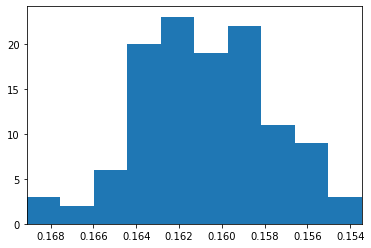

In [92]:
plt.hist(result_df_multi)
plt.xlim(max(result_df_multi),min(result_df_multi))
plt.show()

In [93]:
Score2005 = model.predict(X_2005)
Score2005

array([[0.15630743]], dtype=float32)

(array([ 7., 30., 31., 34., 17.,  4.,  5.,  0.,  0.,  2.]),
 array([ 2.181 ,  4.9629,  7.7448, 10.5267, 13.3086, 16.0905, 18.8724,
        21.6543, 24.4362, 27.2181, 30.    ]),
 <a list of 10 Patch objects>)

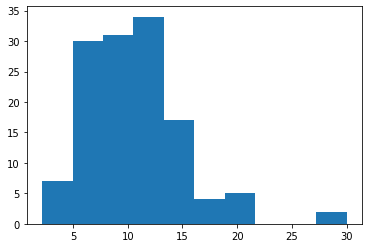

In [94]:
plt.hist(df_sst_final['VK08_TCCount'])

In [95]:
df_regressionAnlysis_multi = pd.DataFrame()
df_regressionAnlysis_multi['StormCount'] = df_final['VK08_TCCount']
df_regressionAnlysis_multi['Year'] = df_final['Year']
df_regressionAnlysis_multi['result']= result_df_multi

In [96]:
df_regressionAnlysis_multi

,StormCount,Year,result
0,12.202,1891,0.159329
1,11.101,1892,0.162008
2,14.041,1893,0.165405
3,9.309,1894,0.161763
4,8.074,1895,0.162619
...,...,...,...
113,15.000,2004,0.155670
114,28.000,2005,0.156307
115,10.000,2006,0.157010
116,15.000,2007,0.153458


In [97]:
Y_data = df_regressionAnlysis_multi['StormCount']
X_data = df_regressionAnlysis_multi['result']

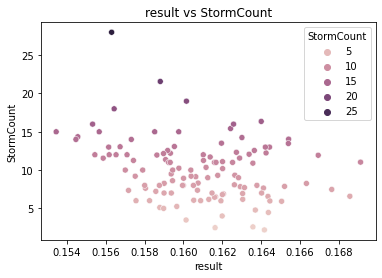

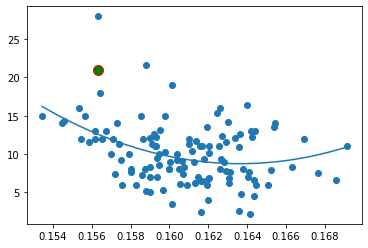

           2
7.219e+04 x - 2.362e+04 x + 1942
0.1457001101796972


In [98]:
# importing packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import scipy.stats as stats
  
dataset = df_regressionAnlysis_multi
sns.scatterplot(data=dataset, x='result', 
                y='StormCount', hue='StormCount')
  
plt.title('result vs StormCount')
plt.xlabel('result')
plt.ylabel('StormCount')
plt.show()
  
# degree 2 polynomial fit or quadratic fit
model2 = np.poly1d(np.polyfit(dataset['result'],
                             dataset['StormCount'], 2))
  
# polynomial line visualization
polyline = np.linspace(max(dataset['result']), min(dataset['result']), 1000)
plt.scatter(dataset['result'], dataset['StormCount'])
plt.plot(polyline, model2(polyline))
plt.plot(Score2005, 21, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.show()
  
print(model2)
  
# r square metric
print(r2_score(dataset['StormCount'], 
               model2(dataset['result'])))

# Upper Half(Outlier) XGBoost Predictions

## Data Cleaning and Pre-Processing

### Gathering Data

In [99]:
df_AMM_JJASOM_mean = pd.read_table('./Data/AMM_JJASOM_mean_1950-2020.dat', sep="\s+", header=None)
df_AMM_JJASOM_mean = df_AMM_JJASOM_mean.rename(columns={0: "Year", 1:"AMM_JJASOM_mean"}).copy()
df_AMM_JJASOM_mean

,Year,AMM_JJASOM_mean
0,1950,1.016667
1,1951,0.916667
2,1952,2.373333
3,1953,1.163333
4,1954,-0.635000
...,...,...
66,2016,1.530000
67,2017,2.618333
68,2018,-2.171667
69,2019,0.566667


In [100]:
df_ERSSTv5_ASO_MDRRelative = pd.read_table('./Data/ERSSTv5_ASO_MDRRelative_SST_1870-2020.dat', sep="\s+", header=None)
df_ERSSTv5_ASO_MDRRelative

,0
0,0.239469
1,-0.396031
2,-0.743195
3,-0.021984
4,0.161659
...,...
146,0.082054
147,0.221386
148,-0.232869
149,-0.098519


In [101]:
df_ERSSTv5_ASO_MDR = pd.read_table('./Data/ERSSTv5_ASO_MDR_SST_1870-2020.dat', sep="\s+", header=None)
df_ERSSTv5_ASO_MDR

,0
0,27.65656
1,27.01905
2,26.62783
3,27.38899
4,27.44587
...,...
146,28.36498
147,28.43985
148,27.93210
149,28.12645


In [102]:
df_ERSSTv5_ASO_MDR_anomalies = pd.read_table('./Data/ERSSTv5_ASO_MDR_SST_anomalies_1870-2020.dat', sep="\s+", header=None)
df_ERSSTv5_ASO_MDR_anomalies

,0
0,-0.233739
1,-0.871247
2,-1.262471
3,-0.501313
4,-0.444434
...,...
146,0.474681
147,0.549548
148,0.041802
149,0.236148


In [103]:
df_ERSSTv5_ASO_MDR_tropics = pd.read_table('./Data/ERSSTv5_ASO_tropics_SST_1870-2020.dat', sep="\s+", header=None)
df_ERSSTv5_ASO_MDR_tropics

,0
0,25.89209
1,25.89008
2,25.84602
3,25.88597
4,25.75921
...,...
146,26.75793
147,26.69346
148,26.63997
149,26.69997


In [104]:
df_ERSSTv5_ASO_MDR_tropics_anomalies = pd.read_table('./Data/ERSSTv5_ASO_tropics_SST_anomalies_1870-2020.dat', sep="\s+", header=None)
df_ERSSTv5_ASO_MDR_tropics_anomalies

,0
0,-0.473208
1,-0.475217
2,-0.519276
3,-0.479329
4,-0.606093
...,...
146,0.392627
147,0.328162
148,0.274671
149,0.334666


In [105]:
df_HURDAT_TCCounts = pd.read_table('./Data/HURDAT_TCCounts_1870-2020.dat', sep="\s+", header=None)
df_HURDAT_TCCounts

,0,1
0,1870,11
1,1871,8
2,1872,5
3,1873,5
4,1874,7
...,...,...
146,2016,15
147,2017,17
148,2018,15
149,2019,18


In [106]:
df_NAO_DJFM_mean = pd.read_table('./Data/NAO_DJFM_mean_1870-2020.dat', sep="\s+", header=None)
df_NAO_DJFM_mean

,0,1
0,1870,0.00275
1,1871,0.05475
2,1872,0.24850
3,1873,1.77750
4,1874,-0.53575
...,...,...
146,2016,1.17500
147,2017,0.39925
148,2018,1.46525
149,2019,2.22850


In [107]:
df_NAO_MJ_mean = pd.read_table('./Data/NAO_MJ_mean_1870-2020.dat', sep="\s+", header=None)
df_NAO_MJ_mean

,0,1
0,1870,1.0530
1,1871,-1.9325
2,1872,-0.1640
3,1873,-0.0725
4,1874,-1.3055
...,...,...
146,2016,-1.0485
147,2017,-0.0835
148,2018,0.3060
149,2019,-0.3895


In [108]:
df_Nino12_DJF = pd.read_table('./Data/Nino12_DJF_1870-2020.dat', sep="\s+", header=None)
df_Nino12_DJF

,0,1
0,1870,-0.850000
1,1871,-1.156667
2,1872,-1.003333
3,1873,-1.156667
4,1874,-0.676667
...,...,...
146,2016,0.423333
147,2017,-1.073333
148,2018,0.706667
149,2019,-0.113333


In [109]:
df_Nino34_DJF = pd.read_table('./Data/Nino34_DJF_1870-2020.dat', sep="\s+", header=None)
df_Nino34_DJF

,0,1
0,1870,-0.540000
1,1871,-0.640000
2,1872,-0.890000
3,1873,-0.896667
4,1874,-0.740000
...,...,...
146,2016,-0.286667
147,2017,-0.813333
148,2018,0.700000
149,2019,0.543333


In [110]:
df_Nino3_DJF = pd.read_table('./Data/Nino3_DJF_1870-2020.dat', sep="\s+", header=None)
df_Nino3_DJF

,0,1
0,1870,-0.573333
1,1871,-0.710000
2,1872,-1.046667
3,1873,-1.276667
4,1874,-0.793333
...,...,...
146,2016,-0.056667
147,2017,-1.010000
148,2018,0.720000
149,2019,0.273333


In [111]:
df_SahelPrecipIndex_JJAS_mean = pd.read_table('./Data/SahelPrecipIndex_JJAS_mean_1901-2017.dat', sep="\s+", header=None)
df_SahelPrecipIndex_JJAS_mean = df_SahelPrecipIndex_JJAS_mean.rename(columns={0: "Year", 1:"SahelPrecipIndex_JJAS_mean"}).copy()

In [112]:
df_SahelPrecipIndex_JJAS_mean

,Year,SahelPrecipIndex_JJAS_mean
0,1901,3.7100
1,1902,0.1200
2,1903,2.0825
3,1904,0.9850
4,1905,2.5625
...,...,...
112,2013,0.6425
113,2014,0.5050
114,2015,3.0375
115,2016,2.5250


In [113]:
df_VK08_TCCount = pd.read_table('./Data/VK08_TCCounts_1878-2020.dat', sep="\s+", header=None)
df_VK08_TCCount = df_VK08_TCCount.rename(columns={0: "Year", 1:"VK08_TCCount"}).copy()
df_VK08_TCCount

,Year,VK08_TCCount
0,1878,15.370
1,1879,11.308
2,1880,14.084
3,1881,10.234
4,1882,9.183
...,...,...
138,2016,15.000
139,2017,17.000
140,2018,15.000
141,2019,18.000


In [114]:
df_hurricanefinal = pd.DataFrame()

In [115]:
df_hurricanefinal['Year'] = df_HURDAT_TCCounts[0]
df_hurricanefinal['HURRICANE_COUNT'] = df_HURDAT_TCCounts[1]

df_hurricanefinal['ERSSTv5_ASO_MDRRelative'] = df_ERSSTv5_ASO_MDRRelative[0]
df_hurricanefinal['ERSSTv5_ASO_MDR'] = df_ERSSTv5_ASO_MDR[0] 
df_hurricanefinal['ERSSTv5_ASO_MDR_anomalies'] = df_ERSSTv5_ASO_MDR_anomalies[0] 
df_hurricanefinal['ERSSTv5_ASO_MDR_tropics'] = df_ERSSTv5_ASO_MDR_tropics[0] 
df_hurricanefinal['ERSSTv5_ASO_MDR_tropics_anomalies'] = df_ERSSTv5_ASO_MDR_tropics_anomalies[0] 
df_hurricanefinal['ERSSTv5_ASO_MDR'] = df_ERSSTv5_ASO_MDR[0] 

df_hurricanefinal['NAO_DJFM_mean'] = df_NAO_DJFM_mean[1]
df_hurricanefinal['NAO_MJ_mean'] = df_NAO_MJ_mean[1] 

df_hurricanefinal['Nino12_DJF'] = df_Nino12_DJF[1]
df_hurricanefinal['Nino34_DJF'] = df_Nino34_DJF[1] 
df_hurricanefinal['Nino3_DJF'] = df_Nino3_DJF[1]

In [116]:
df_hurricanefinal = pd.merge(df_hurricanefinal, df_AMM_JJASOM_mean,how = "left", on=['Year'])
df_hurricanefinal = pd.merge(df_hurricanefinal, df_VK08_TCCount,how = "left", on=['Year'])
df_hurricanefinal = pd.merge(df_hurricanefinal, df_SahelPrecipIndex_JJAS_mean,how = "left", on=['Year'])

### Data Pre-processing

In [117]:
df_hurricanefinal

,Year,HURRICANE_COUNT,ERSSTv5_ASO_MDRRelative,ERSSTv5_ASO_MDR,ERSSTv5_ASO_MDR_anomalies,ERSSTv5_ASO_MDR_tropics,ERSSTv5_ASO_MDR_tropics_anomalies,NAO_DJFM_mean,NAO_MJ_mean,Nino12_DJF,Nino34_DJF,Nino3_DJF,AMM_JJASOM_mean,VK08_TCCount,SahelPrecipIndex_JJAS_mean
0,1870,11,0.239469,27.65656,-0.233739,25.89209,-0.473208,0.00275,1.0530,-0.850000,-0.540000,-0.573333,NaN,NaN,NaN
1,1871,8,-0.396031,27.01905,-0.871247,25.89008,-0.475217,0.05475,-1.9325,-1.156667,-0.640000,-0.710000,NaN,NaN,NaN
2,1872,5,-0.743195,26.62783,-1.262471,25.84602,-0.519276,0.24850,-0.1640,-1.003333,-0.890000,-1.046667,NaN,NaN,NaN
3,1873,5,-0.021984,27.38899,-0.501313,25.88597,-0.479329,1.77750,-0.0725,-1.156667,-0.896667,-1.276667,NaN,NaN,NaN
4,1874,7,0.161659,27.44587,-0.444434,25.75921,-0.606093,-0.53575,-1.3055,-0.676667,-0.740000,-0.793333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2016,15,0.082054,28.36498,0.474681,26.75793,0.392627,1.17500,-1.0485,0.423333,-0.286667,-0.056667,1.530000,15.0,2.5250
147,2017,17,0.221386,28.43985,0.549548,26.69346,0.328162,0.39925,-0.0835,-1.073333,-0.813333,-1.010000,2.618333,17.0,1.2625
148,2018,15,-0.232869,27.93210,0.041802,26.63997,0.274671,1.46525,0.3060,0.706667,0.700000,0.720000,-2.171667,15.0,NaN
149,2019,18,-0.098519,28.12645,0.236148,26.69997,0.334666,2.22850,-0.3895,-0.113333,0.543333,0.273333,0.566667,18.0,NaN


In [118]:
df_hurricanefinalVK08Counts = df_hurricanefinal.dropna(subset=['VK08_TCCount'])

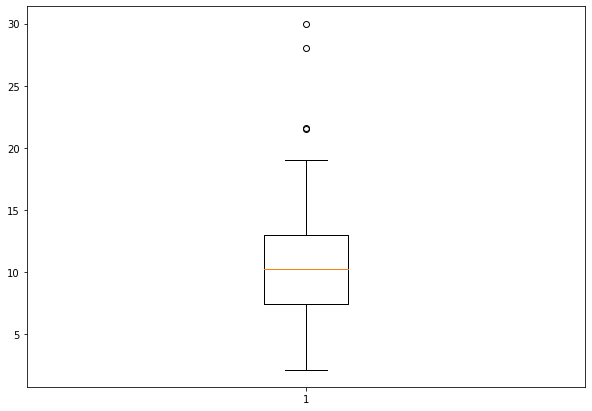

In [119]:
fig = plt.figure(figsize =(10, 7))
# Creating plot
plt.boxplot(df_hurricanefinalVK08Counts['VK08_TCCount'])
# show plot
plt.show()

In [120]:
df_hurricanefinalVK08Counts.head(70)

,Year,HURRICANE_COUNT,ERSSTv5_ASO_MDRRelative,ERSSTv5_ASO_MDR,ERSSTv5_ASO_MDR_anomalies,ERSSTv5_ASO_MDR_tropics,ERSSTv5_ASO_MDR_tropics_anomalies,NAO_DJFM_mean,NAO_MJ_mean,Nino12_DJF,Nino34_DJF,Nino3_DJF,AMM_JJASOM_mean,VK08_TCCount,SahelPrecipIndex_JJAS_mean
8,1878,12,0.782837,28.55411,0.663813,26.24628,-0.119023,-0.81125,-0.6320,-0.373333,-0.493333,-0.540000,NaN,15.370,NaN
9,1879,8,0.591066,28.04251,0.152207,25.92644,-0.438859,0.74400,0.0680,-0.133333,-0.916667,-0.873333,NaN,11.308,NaN
10,1880,11,0.067194,27.45252,-0.437781,25.86032,-0.504975,-1.30050,-0.6660,-0.103333,0.233333,0.040000,NaN,14.084,NaN
11,1881,7,0.286079,27.76526,-0.125039,25.95418,-0.411118,3.16025,0.4140,-0.673333,-0.456667,-0.613333,NaN,10.234,NaN
12,1882,6,0.081678,27.46557,-0.424733,25.85889,-0.506411,0.29575,-0.6590,-1.133333,-0.566667,-0.766667,NaN,9.183,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1943,10,0.058492,27.60058,-0.289724,26.01708,-0.348216,0.20825,2.0405,-0.366667,-0.226667,-0.296667,NaN,11.960,3.0675
74,1944,11,0.005687,27.81003,-0.080266,26.27935,-0.085954,1.33025,-1.1770,-0.480000,-0.363333,-0.460000,NaN,12.556,0.1775
75,1945,11,0.721561,28.54538,0.655082,26.29882,-0.066479,0.44100,-0.2360,-0.476667,-0.406667,-0.630000,NaN,13.077,2.8950
76,1946,6,-0.030884,27.34187,-0.548431,25.84775,-0.517547,-1.06850,-0.0735,-0.330000,0.096667,-0.040000,NaN,7.710,2.1600


In [121]:
df_hurricanefinalVK08Counts['VK08_TCCount_yearBefore'] = df_hurricanefinalVK08Counts['VK08_TCCount'].shift(1)
df_hurricanefinalVK08Counts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Year,HURRICANE_COUNT,ERSSTv5_ASO_MDRRelative,ERSSTv5_ASO_MDR,ERSSTv5_ASO_MDR_anomalies,ERSSTv5_ASO_MDR_tropics,ERSSTv5_ASO_MDR_tropics_anomalies,NAO_DJFM_mean,NAO_MJ_mean,Nino12_DJF,Nino34_DJF,Nino3_DJF,AMM_JJASOM_mean,VK08_TCCount,SahelPrecipIndex_JJAS_mean,VK08_TCCount_yearBefore
8,1878,12,0.782837,28.55411,0.663813,26.24628,-0.119023,-0.81125,-0.6320,-0.373333,-0.493333,-0.540000,NaN,15.370,NaN,NaN
9,1879,8,0.591066,28.04251,0.152207,25.92644,-0.438859,0.74400,0.0680,-0.133333,-0.916667,-0.873333,NaN,11.308,NaN,15.370
10,1880,11,0.067194,27.45252,-0.437781,25.86032,-0.504975,-1.30050,-0.6660,-0.103333,0.233333,0.040000,NaN,14.084,NaN,11.308
11,1881,7,0.286079,27.76526,-0.125039,25.95418,-0.411118,3.16025,0.4140,-0.673333,-0.456667,-0.613333,NaN,10.234,NaN,14.084
12,1882,6,0.081678,27.46557,-0.424733,25.85889,-0.506411,0.29575,-0.6590,-1.133333,-0.566667,-0.766667,NaN,9.183,NaN,10.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2016,15,0.082054,28.36498,0.474681,26.75793,0.392627,1.17500,-1.0485,0.423333,-0.286667,-0.056667,1.530000,15.000,2.5250,11.000
147,2017,17,0.221386,28.43985,0.549548,26.69346,0.328162,0.39925,-0.0835,-1.073333,-0.813333,-1.010000,2.618333,17.000,1.2625,15.000
148,2018,15,-0.232869,27.93210,0.041802,26.63997,0.274671,1.46525,0.3060,0.706667,0.700000,0.720000,-2.171667,15.000,NaN,17.000
149,2019,18,-0.098519,28.12645,0.236148,26.69997,0.334666,2.22850,-0.3895,-0.113333,0.543333,0.273333,0.566667,18.000,NaN,15.000


In [122]:
df_hurricanefinalVK08CountsUpper = df_hurricanefinalVK08Counts.loc[df_hurricanefinalVK08Counts['Year'].isin(OutlierYearList)]
df_hurricanefinalVK08CountsUpper.reset_index(inplace=True, drop=True)

In [123]:
df_hurricanefinalVK08CountsUpper

,Year,HURRICANE_COUNT,ERSSTv5_ASO_MDRRelative,ERSSTv5_ASO_MDR,ERSSTv5_ASO_MDR_anomalies,ERSSTv5_ASO_MDR_tropics,ERSSTv5_ASO_MDR_tropics_anomalies,NAO_DJFM_mean,NAO_MJ_mean,Nino12_DJF,Nino34_DJF,Nino3_DJF,AMM_JJASOM_mean,VK08_TCCount,SahelPrecipIndex_JJAS_mean,VK08_TCCount_yearBefore
0,1891,10,0.158226,27.59291,-0.297395,25.90968,-0.455621,-0.41600,-2.7580,-0.316667,-0.276667,-0.336667,NaN,12.202,NaN,5.871
1,1896,7,-0.022324,27.68740,-0.202905,26.18472,-0.180581,1.28100,-0.5790,1.173333,1.393333,1.370000,NaN,8.929,NaN,8.074
2,1917,3,-0.398016,26.68874,-1.201560,25.56176,-0.803544,0.24025,-0.3925,-0.896667,-0.793333,-1.006667,NaN,5.110,1.8675,15.423
3,1918,5,-0.150771,27.20146,-0.688844,25.82723,-0.538073,0.39500,0.7705,1.003333,1.380000,1.300000,NaN,7.626,3.4125,5.110
4,1920,4,-0.376603,26.90749,-0.982814,25.75909,-0.606212,1.37300,-0.4265,-0.400000,-0.033333,0.036667,NaN,4.994,3.1000,4.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2016,15,0.082054,28.36498,0.474681,26.75793,0.392627,1.17500,-1.0485,0.423333,-0.286667,-0.056667,1.530000,15.000,2.5250,11.000
59,2017,17,0.221386,28.43985,0.549548,26.69346,0.328162,0.39925,-0.0835,-1.073333,-0.813333,-1.010000,2.618333,17.000,1.2625,15.000
60,2018,15,-0.232869,27.93210,0.041802,26.63997,0.274671,1.46525,0.3060,0.706667,0.700000,0.720000,-2.171667,15.000,NaN,17.000
61,2019,18,-0.098519,28.12645,0.236148,26.69997,0.334666,2.22850,-0.3895,-0.113333,0.543333,0.273333,0.566667,18.000,NaN,15.000


In [124]:
df_hurricanefinalVK08CountsUpper = pd.merge(df_hurricanefinalVK08CountsUpper, df_regressionAnlysis[['Year', 'result']], on=['Year'], how="left")

In [125]:
#df_hurricanefinalVK08CountsUpper = df_hurricanefinalVK08CountsUpper[['ERSSTv5_ASO_MDRRelative','Nino34_DJF', 'result','VK08_TCCount_yearBefore', 'NAO_DJFM_mean','HURRICANE_COUNT',"VK08_TCCount", 'Year']]

In [126]:
df_hurricanefinalVK08CountsUpper.tail(30)

,Year,HURRICANE_COUNT,ERSSTv5_ASO_MDRRelative,ERSSTv5_ASO_MDR,ERSSTv5_ASO_MDR_anomalies,ERSSTv5_ASO_MDR_tropics,ERSSTv5_ASO_MDR_tropics_anomalies,NAO_DJFM_mean,NAO_MJ_mean,Nino12_DJF,Nino34_DJF,Nino3_DJF,AMM_JJASOM_mean,VK08_TCCount,SahelPrecipIndex_JJAS_mean,VK08_TCCount_yearBefore,result
33,1981,12,-0.119242,27.62595,-0.264354,26.22019,-0.145112,0.24975,-0.7640,-0.213333,-0.033333,0.166667,0.478333,12.0,-0.0750,11.0,0.161224
34,1982,6,-0.418152,27.43625,-0.454045,26.32941,-0.035893,2.00150,-0.3805,2.653333,2.326667,2.803333,-1.913333,6.0,-1.3475,12.0,0.163076
35,1987,7,-0.012204,28.17466,0.284356,26.66186,0.296559,0.09850,-0.6950,0.236667,0.696667,0.556667,0.603333,7.0,-1.1750,6.0,0.163934
36,1988,12,-0.030440,27.77029,-0.120010,26.27573,-0.089570,2.86100,-1.9940,-0.400000,-1.766667,-1.313333,0.653333,12.0,1.7225,7.0,0.160350
37,1990,14,0.184925,28.06211,0.171805,26.35218,-0.013120,0.20650,-0.3890,-0.210000,0.383333,0.060000,1.161667,14.0,-1.4500,11.0,0.162183
38,1991,8,-0.455967,27.39907,-0.491233,26.33003,-0.035266,1.68100,-0.1780,0.416667,1.616667,1.306667,-2.241667,8.0,-0.4425,14.0,0.162454
39,1994,7,-0.355294,27.42185,-0.468446,26.25215,-0.113152,2.43550,0.7750,0.610000,1.060000,0.786667,-2.145000,7.0,2.2800,8.0,0.163959
40,1995,19,0.213867,28.07606,0.185759,26.33719,-0.028107,-2.32225,-1.8615,-0.536667,-0.676667,-0.616667,2.971667,19.0,0.0525,7.0,0.165160
41,1996,13,0.001114,27.80028,-0.090024,26.27416,-0.091138,0.17400,-0.0355,-0.540000,-0.366667,-0.630000,-0.051667,13.0,-0.1975,19.0,0.161167
42,1997,8,-0.260298,27.92916,0.038857,26.66446,0.299155,0.79850,-2.6975,3.566667,2.266667,2.923333,-0.085000,8.0,-0.8075,13.0,0.164305


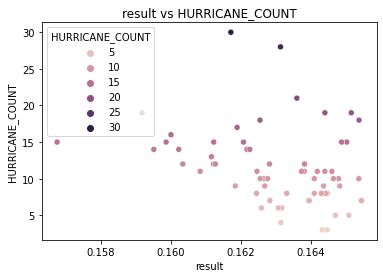

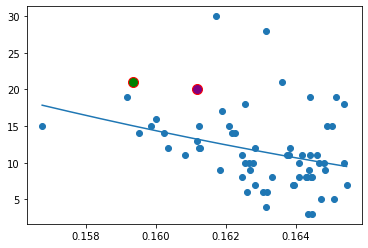

           2
2.008e+04 x - 7433 x + 689.6
0.09977465383344353


In [127]:
dataset = df_hurricanefinalVK08CountsUpper
sns.scatterplot(data=dataset, x='result', 
                y='HURRICANE_COUNT', hue='HURRICANE_COUNT')
  
plt.title('result vs HURRICANE_COUNT')
plt.xlabel('result')
plt.ylabel('HURRICANE_COUNT')
plt.show()
  
# degree 2 polynomial fit or quadratic fit
model2 = np.poly1d(np.polyfit(dataset['result'],
                             dataset['HURRICANE_COUNT'], 2))
  
# polynomial line visualization
polyline = np.linspace(max(dataset['result']), min(dataset['result']), 1000)
plt.scatter(dataset['result'], dataset['HURRICANE_COUNT'])
plt.plot(polyline, model2(polyline))
plt.plot(Score2021, 21, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.plot(Score2022, 20, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="purple")
plt.show()
  
print(model2)
  
# r square metric
print(r2_score(dataset['HURRICANE_COUNT'], 
               model2(dataset['result'])))

## XG BOOST

In [128]:
test2005 = df_hurricanefinalVK08CountsUpper.loc[df_hurricanefinalVK08CountsUpper.Year == 2005].drop(columns=['HURRICANE_COUNT',"VK08_TCCount", 'Year'],axis=1)
test2020 = df_hurricanefinalVK08CountsUpper.loc[df_hurricanefinalVK08CountsUpper.Year == 2020].drop(columns=['HURRICANE_COUNT',"VK08_TCCount", 'Year'],axis=1)
test1999 = df_hurricanefinalVK08CountsUpper.loc[df_hurricanefinalVK08CountsUpper.Year == 1999].drop(columns=['HURRICANE_COUNT',"VK08_TCCount", 'Year'],axis=1)

In [129]:
df_hurricanefinal1 = df_hurricanefinalVK08CountsUpper.loc[df_hurricanefinal.Year != 2005]
#df_hurricanefinal1 = df_hurricanefinal1.loc[df_hurricanefinal1.Year != 2020]

X = df_hurricanefinal1.drop(columns=['HURRICANE_COUNT',"VK08_TCCount", 'Year'],axis=1)
y = df_hurricanefinal1['VK08_TCCount']
#outliers across all years
#3- fold cross validation - see which years we under predicted
# Splitting 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3,random_state=303) 
  
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10) 
  
# Fitting the model 
xgb_r.fit(train_X, train_y) 
  
# Predict the model 
pred = xgb_r.predict(test_X) 
  
# RMSE Computation 
rmse = mean_absolute_error(test_y,pred)

print("MAE : % f" %(rmse))

[13:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE :  4.596101


In [130]:
dtrain = xgb.DMatrix(train_X, label=train_y)
dtest = xgb.DMatrix(test_X, label=test_y)

In [131]:
num_boost_round = 999

Hyper Tuning

In [132]:
"""
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'min_child_weight': [.05,1,1.5,2],
           'n_estimators': [100, 500, 1000],
           'gamma': [0,.5,1,2],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
"""
#Uncomment to Rehypertune Model

'\nparams = { \'max_depth\': [3,6,10],\n           \'learning_rate\': [0.01, 0.05, 0.1],\n           \'min_child_weight\': [.05,1,1.5,2],\n           \'n_estimators\': [100, 500, 1000],\n           \'gamma\': [0,.5,1,2],\n           \'colsample_bytree\': [0.3, 0.7]}\n\nxgbr = xgb.XGBRegressor(seed = 20)\nclf = GridSearchCV(estimator=xgbr, \n                   param_grid=params,\n                   scoring=\'neg_mean_squared_error\', \n                   verbose=1)\nclf.fit(X, y)\nprint("Best parameters:", clf.best_params_)\nprint("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))\n'

In [145]:
params = {'colsample_bytree': 0.3, 'gamma': 3, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.05, 'n_estimators': 1000}
#params = clf.best_params_
params['eval_metric'] = "mae"

In [146]:
xgmodel = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:9.3983
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:8.64595
[2]	Test-mae:7.80107
[3]	Test-mae:7.18661
[4]	Test-mae:6.63663
[5]	Test-mae:6.18776
[6]	Test-mae:5.79819
[7]	Test-mae:5.41893
[8]	Test-mae:5.04777
[9]	Test-mae:4.7191
[10]	Test-mae:4.36437
[11]	Test-mae:4.10991
[12]	Test-mae:3.91381
[13]	Test-mae:3.75004
[14]	Test-mae:3.57335
[15]	Test-mae:3.44901
[16]	Test-mae:3.34117
[17]	Test-mae:3.23612
[18]	Test-mae:3.15833
[19]	Test-mae:3.08276
[20]	Test-mae:3.01414
[21]	Test-mae:2.92478
[22]	Test-mae:2.87712
[23]	Test-mae:2.86047
[24]	Test-mae:2.84841
[25]	Test-mae:2.82442
[26]	Test-mae:2.80253
[27]	Test-mae:2.76485
[28]	Test-mae:2.7806
[29]	Test-mae:2.76294
[30]	Test-mae:2.75746
[31]	Test-mae:2.75322
[32]	Test-mae:2.74522
[33]	Test-mae:2.73741
[34]	Test-mae:2.73835
[35]	Test-mae:2.73385
[36]	Test-mae:2.72159
[37]	Test-mae:2.72106
[38]	Test-mae:2.72574
[39]	Test-mae:2.726
[40]	Test-mae:2.6974
[41]	Test-mae:2.69773
[42]	Test-mae:2.69379
[43]	Test-mae:

In [147]:
show_weights(xgmodel)

Weight,Feature
0.1741,ERSSTv5_ASO_MDR_anomalies
0.1596,ERSSTv5_ASO_MDR
0.1366,ERSSTv5_ASO_MDR_tropics_anomalies
0.0969,ERSSTv5_ASO_MDRRelative
0.0679,SahelPrecipIndex_JJAS_mean
0.0678,Nino34_DJF
0.0519,ERSSTv5_ASO_MDR_tropics
0.0448,AMM_JJASOM_mean
0.0433,Nino3_DJF
0.0375,Nino12_DJF


In [148]:
plt.rcParams['figure.figsize'] = [25, 12.5]

In [149]:
xgb_cv = xgb.cv(dtrain=dtrain, params=params, nfold=3,num_boost_round=50, early_stopping_rounds=10, metrics="mae", as_pandas=True, seed=123)

In [150]:
xgb_cv.head()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,10.804551,0.799565,10.758821,1.795540
1,9.810061,0.717514,9.815042,1.808243
2,8.900451,0.645465,8.943981,1.800600
3,8.092274,0.573907,8.187747,1.837881
4,7.361883,0.521531,7.504495,1.803825


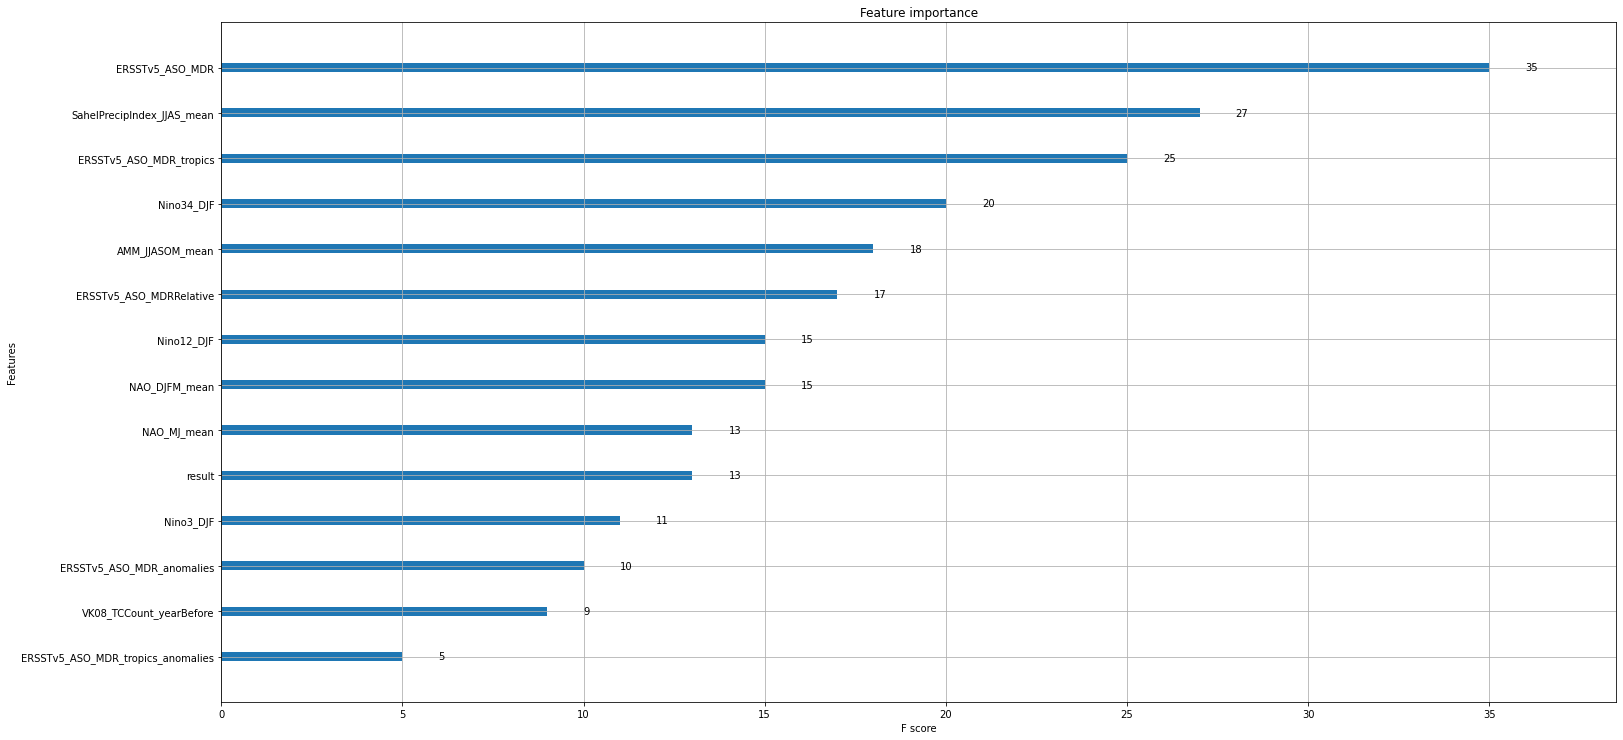

In [151]:
xgb.plot_importance(xgmodel, max_num_features=25)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

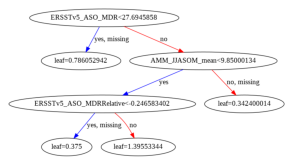

In [152]:
xgb.plot_tree(xgmodel)

In [153]:
explain_prediction(xgmodel, test2005.iloc[0])

Explanation(estimator='<xgboost.core.Booster object at 0x7f2e50b2e250>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=11.926857149208336, std=None, value=1.0), FeatureWeight(feature='ERSSTv5_ASO_MDR', weight=4.457653252431971, std=None, value=28.43595), FeatureWeight(feature='SahelPrecipIndex_JJAS_mean', weight=2.717925325126538, std=None, value=0.4725), FeatureWeight(feature='ERSSTv5_ASO_MDR_anomalies', weight=1.6275347894515149, std=None, value=0.5456474), FeatureWeight(feature='ERSSTv5_ASO_MDRRelative', weight=0.8080969497915647, std=None, value=0.4560429), FeatureWeight(feature='Nino12_DJF', weight=0.7948020752467944, std=None, value=-0.516666667), FeatureWeight(feature='NAO_DJFM_mean', weight=0.6820184291380683, std=None, value=-0.81775), FeatureWeight(feature='ERSSTv5_ASO_MDR_tropics', weight=0.6063893239156829, std=None, value=26.4549), FeatureWeight(feature='Nino34_DJF', weight=0.5941924017838598, std=None, value=-0.813333333), FeatureWeight(feature='NAO_MJ_mean', weight=0.5008265204435246, std=None, value=-0.5675), FeatureWeight(feature='AMM_JJASOM_mean', weight=0.4932873112094326, std=None, value=4.048333333), FeatureWeight(feature='Nino3_DJF', weight=0.4775832840940476, std=None, value=-0.856666667), FeatureWeight(feature='result', weight=0.33299671475666665, std=None, value=0.16313806176185608), FeatureWeight(feature='ERSSTv5_ASO_MDR_tropics_anomalies', weight=0.22453626038454533, std=None, value=0.08960456), FeatureWeight(feature='VK08_TCCount_yearBefore', weight=0.16134945897724357, std=None, value=15.0)], neg=[], pos_remaining=0, neg_remaining=0), proba=None, score=26.406049245959803, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [154]:
explain_prediction(xgmodel, test2020.iloc[0])

Explanation(estimator='<xgboost.core.Booster object at 0x7f2e50b2e250>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=11.926857149208336, std=None, value=1.0), FeatureWeight(feature='ERSSTv5_ASO_MDR', weight=4.457653252431971, std=None, value=28.3531), FeatureWeight(feature='SahelPrecipIndex_JJAS_mean', weight=3.3489902237181397, std=None, value=nan), FeatureWeight(feature='ERSSTv5_ASO_MDR_anomalies', weight=1.6275347894515149, std=None, value=0.4627979), FeatureWeight(feature='ERSSTv5_ASO_MDR_tropics', weight=0.952970024071826, std=None, value=26.64466), FeatureWeight(feature='ERSSTv5_ASO_MDRRelative', weight=0.8992188226415647, std=None, value=0.183437), FeatureWeight(feature='Nino12_DJF', weight=0.8750105576601277, std=None, value=-0.633), FeatureWeight(feature='Nino34_DJF', weight=0.5941924017838598, std=None, value=-0.987), FeatureWeight(feature='NAO_DJFM_mean', weight=0.5891190105659254, std=None, value=-0.135), FeatureWeight(feature='Nino3_DJF', weight=0.5787733053518255, std=None, value=-0.65), FeatureWeight(feature='AMM_JJASOM_mean', weight=0.5331774886577126, std=None, value=1.46783), FeatureWeight(feature='NAO_MJ_mean', weight=0.3983674123497746, std=None, value=-0.806), FeatureWeight(feature='result', weight=0.33299671475666665, std=None, value=0.1617211401462555), FeatureWeight(feature='VK08_TCCount_yearBefore', weight=0.22728707809999996, std=None, value=18.0), FeatureWeight(feature='ERSSTv5_ASO_MDR_tropics_anomalies', weight=0.22453626038454533, std=None, value=0.2793609)], neg=[], pos_remaining=0, neg_remaining=0), proba=None, score=27.566684491133802, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [155]:
explain_prediction(xgmodel, test1999.iloc[0])

Explanation(estimator='<xgboost.core.Booster object at 0x7f2e50b2e250>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=11.926857149208336, std=None, value=1.0), FeatureWeight(feature='ERSSTv5_ASO_MDRRelative', weight=0.7838612406708751, std=None, value=0.2835747), FeatureWeight(feature='Nino34_DJF', weight=0.49143540055101476, std=None, value=-1.62), FeatureWeight(feature='result', weight=0.19375019945928235, std=None, value=0.16127872467041016), FeatureWeight(feature='ERSSTv5_ASO_MDR', weight=0.10823197438558817, std=None, value=27.93422), FeatureWeight(feature='Nino12_DJF', weight=0.013110039564582517, std=None, value=-0.806666667), FeatureWeight(feature='VK08_TCCount_yearBefore', weight=0.0022725420199102703, std=None, value=14.0)], neg=[FeatureWeight(feature='ERSSTv5_ASO_MDR_tropics', weight=-0.5988498791657544, std=None, value=26.12564), FeatureWeight(feature='NAO_MJ_mean', weight=-0.34196992844554097, std=None, value=1.2065), FeatureWeight(feature='SahelPrecipIndex_JJAS_mean', weight=-0.2944005066344991, std=None, value=2.64), FeatureWeight(feature='ERSSTv5_ASO_MDR_tropics_anomalies', weight=-0.21667475892749788, std=None, value=-0.2396572), FeatureWeight(feature='AMM_JJASOM_mean', weight=-0.13681636457683027, std=None, value=0.975), FeatureWeight(feature='NAO_DJFM_mean', weight=-0.09875662390132468, std=None, value=1.84575), FeatureWeight(feature='ERSSTv5_ASO_MDR_anomalies', weight=-0.08385775062674641, std=None, value=0.04391745), FeatureWeight(feature='Nino3_DJF', weight=-0.07715884458160466, std=None, value=-1.44)], pos_remaining=0, neg_remaining=0), proba=None, score=11.671033888999792, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)